> ### EEE4423: Signal Processing Lab

# LAB \#12: Sequence to Sequence Network with Attetion Module
## Machine Translation with Attention

<h4><div style="text-align: right"> Due date:  </div> <br>
<div style="text-align: right"> Please upload your file @ yscec by 9 PM in the form of [ID_Name_Lab12.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">2014142243 차현수</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2021-05-24 17:57:27.117013


In this project we will be teaching a neural network to translate from
French to English.
*************************************************************
::

    [(>): input, (=): target, (<): output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

...
*************************************************************

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Prepare data

The data for this project is a set of many thousands of English to French translation pairs. Download the data from <https://download.pytorch.org/tutorial/data.zip>. The file is a tab separated list of translation pairs:


    I am cold.    J'ai froid.
    
<img src="https://drive.google.com/uc?export=view&id=1K3W2RxeTKih5IiT5PcIyWNZSwMqtYSGZ"  onerror="this.style.display='none'" style="width: 600px;"/><br><br>

In [3]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ")

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    # Read the file and split into lines
    lines = open('dataset/lab12/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:", input_lang.name, '=', input_lang.n_words, output_lang.name, '=', output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counted words: fra = 4345 eng = 2803
['tu n es pas habillee .', 'you re not dressed .']


In [4]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 2. Build the Seq2Seq model [5 points]

<img src="https://drive.google.com/uc?export=view&id=1kKXrIIxi0t-Nm5HfzOukqjzEp7yEXEpV"  onerror="this.style.display='none'" /><br><br>

[sequence to sequence network](https://arxiv.org/abs/1409.3215) is a model in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a single vector,
and a decoder network unfolds that vector into a new sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

#### Encoder
The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.  
<img src="https://drive.google.com/uc?export=view&id=1PyKBEVl5jwQfB0I0P2kG8nTGQVZQdZEM"  onerror="this.style.display='none'" /><br><br>

#### GRU
<img src="https://drive.google.com/uc?export=view&id=1467jVFRYbw1DYvVKeSyzGWLRmtlqpy8z"  onerror="this.style.display='none'" style="width: 700px;"/><br><br>
The GRU operates using a reset gate (r) and an update gate (z). The candidate state is created by using the previous hidden state and the current input. It is the reset gate that determines how the previous hidden state affects the candidate state. The newly created candidate state and the previous hidden state create a new hidden state, in which the update gate plays a role in balancing the two.

#### LSTM vs GRU
<img src="https://drive.google.com/uc?export=view&id=1lzGTsIYvPWKNF-XaTevMaaZvjfgp9G35"  onerror="this.style.display='none'" style="width: 600px;"/><br><br>

| <center>LSTM</center> | <center>GRU</center>  |
|:--------|--------|
| LSTM has 3 gates (forget, input, output) | GRU has 2 gates (reset, update) |
| There is an internal memory (cell state) | There is no cell state and only hidden state exists |
| When making output, another non-linearity is applied | There is no additional non-linearity when making output  |

In [5]:
# 2 points
class EncoderRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(EncoderRNN, self).__init__()
        
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(input_dim, hidden_dim)

        # gru
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #############
        # CODE HERE #
        self.gru = nn.GRU(hidden_dim, hidden_dim)
        #############

    def forward(self, input, hn):
        #############
        # CODE HERE #
        input = self.embedding(input).view(1, 1, -1)
        output = input
        output, hn = self.gru(output, hn)
        #############
        return output, hn

    def initHidden(self):
        # The size of h0 should be (layer_dim, batch_size, hidden_dim)
        #############
        # CODE HERE #
        h0 = torch.zeros(1, 1, self.hidden_dim, device=device)
        #############
        return h0
    
hidden_dim = 256
encoder = EncoderRNN(input_lang.n_words, hidden_dim).to(device)

#### Decoder
<img src="https://drive.google.com/uc?export=view&id=1Rm_LlpEolCvPuzPWEFOZ-zdTfsgMbtu-"  onerror="this.style.display='none'" /><br><br>

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence. Attention allows the decoder network to "focus" on a specific part of
the encoder's outputs for every step and thus help the decoder choose the right output words. 

<img src="https://drive.google.com/uc?export=view&id=18hsS8PAA7I3QaN9oOebfnMGAMhR-6EID"  onerror="this.style.display='none'" style="width: 170px;"/><br><br>

<img src="https://drive.google.com/uc?export=view&id=1F1Y92uLvGaI6s-ygyNKNox4ZGiZmTZ3g"  onerror="this.style.display='none'" style="width: 170px;"/><br><br>

The attention weights are calculated using an another feed-forward layer which inputs the decoder's input and hidden state. And the calculated attention weight is multiplied to the corresponding hidden state of the encoder, respectively. Note that to actually create and train this layer we have to choose a maximum sentence length. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

<img src="https://drive.google.com/uc?export=view&id=1JEE23gtJf4XciJUXLt2R9lZtpRn8mYCN"  onerror="this.style.display='none'" /><br><br>

In [6]:
# 3 points
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_dim, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        
        # attention
        # Note that the column of the attention weights is MAX_LENGTH
        # Note that concatenation is used when "attn" and "attn_combine" are created
        #############
        # CODE HERE #
        self.max_length = MAX_LENGTH
        self.attn = nn.Linear(self.hidden_dim * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        #############
        
        # gru
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #############
        # CODE HERE #
        self.gru = nn.GRU(self.hidden_dim, self.hidden_dim)
        #############
        
        self.out = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, input, hn, encoder_outputs):
        input = self.embedding(input).view(1, 1, -1)
        input = self.dropout(input)
        
        # attention
        # All specifications of the operations are described in the above figure (e.g. use ReLU)
        # bmm is a operation which performs a batch matrix-matrix product
        #############
        # CODE HERE #
        attn_weights = F.softmax(self.attn(torch.cat((input[0], hn[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((input[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        #############
        
        # gru
        #############
        # CODE HERE #
        output = F.relu(output)
        output, hn = self.gru(output, hn)
        #############
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hn

    def initHidden(self):
        # The size of h0 should be (layer_dim, batch_size, hidden_dim)
        #############
        # CODE HERE #
        h0 = torch.zeros(1, 1, self.hidden_dim, device=device)
        #############
        return h0
    
decoder = AttnDecoderRNN(hidden_dim, output_lang.n_words, dropout_p=0.1).to(device)

### 3. loss function and optimizer

In [7]:
criterion = nn.NLLLoss()

learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

### 4. Write the evaluation code [2 points]

In [8]:
def evaluate(sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        #############
        # CODE HERE #
        encoder_hidden = encoder.initHidden()
        #############
        
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device)
        
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoded_words = []
        
        #############
        # CODE HERE #
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            
        decoder_hidden = encoder_hidden
        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        #############

        return decoded_words
    
def evaluateRandomly():
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print('')

### 5 . Write the code to train the model [3 points]

During training, use the ``Teacher forcing`` concept in addition to a naive approach. In other words, instead of using the decoder's guess as the next input, the real target outputs are also used sometimes. This shows faster convergene.

************************* iter1000 *************************
loss 16.1061
> tu es responsable de ce resultat .
= you are responsible for the result .
< you re not a . <EOS>

************************* iter2000 *************************
loss 14.1632
> vous etes tres habiles .
= you re very clever .
< you re very very . <EOS>

************************* iter3000 *************************
loss 29.4210
> je ne suis pas encore pret .
= i m not ready yet .
< i m not sure . <EOS>

************************* iter4000 *************************
loss 24.7786
> vous etes le champion n est ce pas ?
= you re the champion aren t you ?
< you re the oldest aren t you ? <EOS>

************************* iter5000 *************************
loss 25.3934
> nous sommes bourrees .
= we re smashed .
< we re in the . <EOS>

************************* iter6000 *************************
loss 13.4960
> c est mon ami intime .
= he is my close friend .
< he s my friend . <EOS>

************************* iter7000 ********

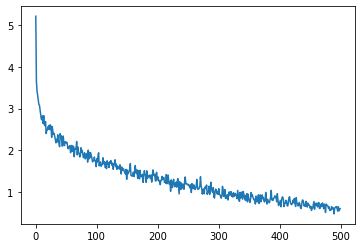

In [9]:
n_iters = 50000
print_every = 1000
plot_every =100

plot_losses = []
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every

training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

for iter in range(1, n_iters+1):
    #############
    # CODE HERE #
    #############
    # Load data
    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]
    
    # Clear gradients w.r.t. parameters
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Forward pass
    loss = 0
    input_length = input_tensor.size(0)
    
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_dim, device=device)
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    decoder_hidden = encoder_hidden
    
    # Teacher forcing: Feed the target as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing
            
    # Backward pass
    loss.backward()
    
    # Updating parameters
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    print_loss_total += loss.item() / target_length
    plot_loss_total += loss.item() / target_length

    if iter % print_every == 0:
        print('*'*25, 'iter%d'%iter, '*'*25)
        print('loss %.4f'%loss)
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        evaluateRandomly()

    if iter % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

#################################################
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(plot_losses)

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)